# Final Project: Word Embedding and Dimensionality Reduction
    by Emma Cai

## 1. Import packages:
    For NLP, I imported re, sent_tokenize, word_tokenize, stopwords and PorterStemmer from nltk.
    For dimensionality reduction, I imported TSNE,LDA from sklearn and Word2Vec from gensim. 
    For visualization, I imported pyplot from matplotlib.
    For graph convolutional network, I imported GraphConv from keras_gcn

In [1]:
import re 
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import keras
from keras_gcn import GraphConv

Using TensorFlow backend.


## 2. Build the corpus:
    As I took the CSCI-B455 class, I find the assignment sheets for homeworks and projects
    can be used for clusting and learning the simility between the words.
    Here I tokenized sentances form homewoks and projects seperately 
    and stored it in "corpus_proj" and "corpus_hw".

In [2]:
corpus_proj = []
corpus_hw = []
for i in range(5):
    # load projects to corpus_proj
    filename = 'proj'+str(i+1)+'.txt'
    f = open(filename, 'r')
    text = f.read()
    corpus_proj += sent_tokenize(text)
    f.close()
    # load homewords to corpus_hw
    filename = 'HW'+str(i+1)+'.txt'
    f = open(filename, 'r')
    text = f.read()
    corpus_hw += sent_tokenize(text)
    f.close()

## 3. Clean text data and tokenizes it:
    The unwanted characters from the texts are stripped.
    The cleaned text are being tokenized into words.
    First, meaningless word (stop words) are being filtered out.
    Then, those words are further being stemmed, which means different forms of words will be the same word.
    Stops words are being filtered out.
    Eventually, I got my new datasets "new_corpus_proj" and "new_corpus_hw".

In [3]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

def tokenizer(text):
    filtered_w = []
    for w in word_tokenize(text):
        if w not in stop_words:
            w = ps.stem(w)
            filtered_w.append(w)
    return " ".join(filtered_w)

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

new_corpus_proj = []
new_corpus_hw = []
for text in corpus_proj:
    new_text = preprocessor(text)
    new_text = tokenizer(new_text)
    new_corpus_proj.append(new_text)
for text in corpus_hw:
    new_text = preprocessor(text)
    new_text = tokenizer(new_text)
    new_corpus_hw.append(new_text)
print("Example for sentences in the new_corpus_proj:\n",new_corpus_hw[:3])

Example for sentences in the new_corpus_proj:
 ['b455 principl machin learn hw1 due jan 31 friday 5pm http iu instructur com cours 1857020 1', 'problem 2 1 use bay rule solv follow problem parti meet person claim school', 'vagu recogn rememb properli decid work probabl case given vagu recogn 1 2 peopl went school b']


## 4. Extract the words:
    I build three sets for words.
    The "words" set is for all the words showed in both homework and project.
    The "proj_words" set is for all the words showed in the project.
    The "hw_words" set is for all the words showed in the homework.
    Notice that some words are in both "proj_words" and "hw_words".

In [4]:
words = []
proj_words = []
hw_words = []
whole_corpus = new_corpus_proj + new_corpus_hw
for text in whole_corpus:
    for word in text.split(' '):
        words.append(word)
for text in new_corpus_proj:
    for word in text.split(' '):
        proj_words.append(word)
for text in new_corpus_hw:
    for word in text.split(' '):
        hw_words.append(word)
words = set(words)
proj_words = set(proj_words)
hw_words = set(hw_words)

## 5. Build the input words and output words for word embedding:
    Here we scan through every sentences in the corpus,
    and get the word and its beighbour within a window of two as inputs and outputs.
    Finally, we have a dataframe with shape (10732, 2).
    In gcd(Graph Convolutional Network), this will be the 10732 egdes.

In [5]:
sentences = []
for sentence in whole_corpus:
    sentences.append(sentence.split())
print("Example for splited sentences in the sentences:\n",sentences[:3])

WINDOW = 2
data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx-WINDOW,0) : 
                 min(idx+WINDOW, len(sentence))+1]:
            if neighbor != word:
                data.append([word, neighbor])  
df = pd.DataFrame(data, columns=['input', 'output'])
df.head()

Example for splited sentences in the sentences:
 [['iub', 'csci', 'b455', 'spring', '2020', 'principl', 'machin', 'learn', 'project', '1', 'due', '11', '59pm', 'februari', '18'], ['1', 'introduct', 'project', 'need', 'build', 'multi', 'layer', 'perceptron', 'mlp', 'model', 'specif', 'dataset', 'predict'], ['wine', 'data', 'set']]


,input,output
0,iub,csci
1,iub,b455
2,csci,iub
3,csci,b455
4,csci,spring


## 6. Convert inputs and outputs to one hot encoding:
    To do this, we build a dictionary called "word2int" 
    where every word has a unique number.    
    Now, we have our "X" and "Y", which the machine can process.
    Also, two hyperparameters for embedding dimension and one hot dimension has been defined.

In [6]:
EMBEDDING_DIM = 32
ONE_HOT_DIM = len(words)

word2int = {}
for i,word in enumerate(words):
    word2int[word] = i
    
ONE_HOT_DIM = len(words)
def index_to_one(idx):
    encode = np.zeros(ONE_HOT_DIM)
    encode[idx] = 1
    return encode

X = []
Y = []
for x, y in zip(df['input'], df['output']):
    X.append(index_to_one(word2int[x]))
    Y.append(index_to_one(word2int[y]))
    

## 7. My implementation for Word Embedding:
    It is just a three layer neural network, 
    where the hidden layer with be the corresponding vector repersantation.

In [7]:
class W2V():
    def __init__(self, m=ONE_HOT_DIM, k=EMBEDDING_DIM):
        '''
        m: number of nodes for input layer
        k: number of nodes for hidden layer
        n: number of nodes for output layer
        '''
        #learning rate
        self.lr = 10
        #how many input data
        self.items = None 
        self.m = m
        self.k = k
        #weight for input layer include bias
        self.w1 = np.random.randn(m+1, k) * 0.5
        #weight for hidden layer include bias
        self.w2 = np.random.randn(k+1, m) * 0.5
        self.b = None
        #input layer
        self.X = None
        #hidden layer
        self.hidden = None
        #tracking loss
        self.loss = []
        
        
    def train(self, X, y, epochs = 1200):
        self.items = X.shape[0]
        self.b = np.ones((self.items, 1))
        self.X = np.concatenate((self.b, X), axis = 1)
        for epoch in range(epochs):
            y_hat = self.forward()
            if (epoch%100 == 0):
                a = self.loss_fun(y_hat, y)
                a = np.sum(a)*(1 / self.items)
                self.loss.append(a)
            dh2 = y_hat-y
            self.backward(dh2)
        return self.loss
    
    def forward(self):
        h1 = np.dot(self.X, self.w1)
        a1 = self.sigmoid(h1)
        self.hidden = np.concatenate((self.b, a1), axis = 1)
        h2 = np.dot(self.hidden, self.w2)
        y_hat = self.softmax(h2)
        return y_hat
    
    def get_vec(self, words):
        vec = np.dot(words, self.w1[1:,:])
        vec = self.sigmoid(vec)
        return vec
    
    def backward(self, dh2):
        dw2 = np.dot(self.hidden.T, dh2)
        self.w2 -= self.lr * dw2 / self.items
        da1 = np.dot(dh2, self.w2.T)
        dh1 = da1 * self.d_sigmoid(self.hidden)
        dh1 = dh1[:, 1:]
        dw1 = np.dot(self.X.T, dh1)
        self.w1 -= self.lr * dw1 / self.items
        
    def sigmoid(self, h):
        a = 1/(1+np.exp(-h))
        return a

    def d_sigmoid(self, a):
        return a*(1-a)
    
    def loss_fun(self, y_hat, y):
        return np.sum(-y * np.log(y_hat), axis = 1)
    def softmax(self, h):
        e = np.exp(h)
        return e/np.sum(e, axis = 1, keepdims=True)

## 8. Define the model, train it and get the vectors:
    First, define the model and train it based on my W2V class.
    Then, we build a "unique_words" matrix to store the one hot encoding for every words.
    When we have a input like "unique_words", we can get the vectors.
    Our vector has the shape (891, 32), which is the same with (ONE_HOT_DIM, EMBEDDING_DIM).
    Eventually, we have a dataframe "vec_df", where we have words and it's corresponding vectors. 

In [8]:
word2vec = W2V()
word2vec.train(np.array(X),np.array(Y))

unique_words = []
w = list(words)
for word in w:
    unique_words.append(index_to_one(word2int[word]))
vectors = word2vec.get_vec(unique_words)
print("The shape of the feature vector is:\n", vectors.shape)
vec_df = pd.DataFrame(vectors)
vec_df.insert(0,'word',np.array(w))
vec_df.tail()

The shape of the feature vector is:
 (891, 32)


,word,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
886,roject,0.645966,0.393632,0.270451,0.172720,0.672281,0.472480,0.567930,0.399810,0.540952,...,0.686310,0.236665,0.781187,0.483852,0.460057,0.186386,0.340585,0.808204,0.622527,0.700780
887,43,0.324261,0.619977,0.451937,0.303368,0.534926,0.438095,0.696861,0.286805,0.481541,...,0.376062,0.486776,0.436565,0.506463,0.365261,0.584648,0.518773,0.308634,0.453459,0.630665
888,extend,0.691844,0.399191,0.614777,0.682627,0.545771,0.320472,0.460940,0.295453,0.386713,...,0.436523,0.650729,0.447974,0.420416,0.456466,0.470407,0.483619,0.355457,0.700721,0.317560
889,devis,0.521346,0.552394,0.725272,0.514204,0.646938,0.230426,0.469890,0.575772,0.696990,...,0.191193,0.613979,0.353827,0.400238,0.265252,0.275459,0.601919,0.281157,0.615920,0.415437
890,program,0.457533,0.803568,0.355077,0.322666,0.582439,0.262266,0.256225,0.389512,0.439905,...,0.550255,0.627277,0.516685,0.510207,0.520608,0.670776,0.749974,0.283620,0.801770,0.402992


## 9. My implementation of PCA and visualization:
    Here we choose two major components and discard others.

In [9]:
def PCA(X, dim_reduced_to=2):
    Mean = np.mean(X.T, axis=1)
    X = X - Mean
    cov_matrix = np.cov(X.T)
    eigen_values, eigenvector_matrix = np.linalg.eig(cov_matrix)
    idx = np.argsort(eigen_values)[::-1]
    eigen_vec = eigenvector_matrix[:,idx]
    eigen_vec = eigen_vec[:, :2]
    Y = np.dot(X,eigen_vec)
    print(eigen_values[idx])
    return Y

new_X = PCA(vectors)

[0.05491435 0.04832313 0.04081674 0.04002065 0.03972987 0.0369382
 0.03622573 0.03524605 0.03367423 0.03272758 0.03141634 0.02971507
 0.02932993 0.0288124  0.02753446 0.02694701 0.02631844 0.02467872
 0.02432317 0.02378906 0.02348413 0.02318463 0.0222614  0.02184566
 0.02109686 0.0207531  0.02040748 0.02011146 0.01888462 0.0173481
 0.0167575  0.01481932]


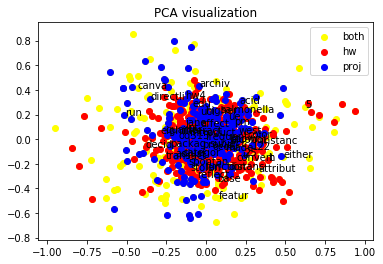

In [10]:
fig, ax = plt.subplots()
n = np.linspace(0,600, num=50, dtype='int')
for i in n:
    ax.annotate(w[i], (new_X[i,0],new_X[i,1]))
only_hw_idx = []
only_proj_idx = []
for i,word in enumerate(w):
    if word not in proj_words:
        only_hw_idx.append(i)
    if word not in hw_words:
        only_proj_idx.append(i)
    
ax.scatter(new_X[:,0],new_X[:,1], c='yellow', label = 'both')
ax.scatter(new_X[only_hw_idx,0],new_X[only_hw_idx,1], c='red', label='hw')
ax.scatter(new_X[only_proj_idx,0],new_X[only_proj_idx,1], c='blue', label='proj')
plt.legend()
plt.title("PCA visualization")
plt.show()

## 10. T-SNE model and visualization:
    T-SNE repersented for t-Distributed Stochastic Neighbor Embedding.
    It is used to show the clusting from a high dimension to a low one.
    In this case, the clusting is not obvious.

In [11]:
model = TSNE(n_components=2)
tsne_X = model.fit_transform(vectors)

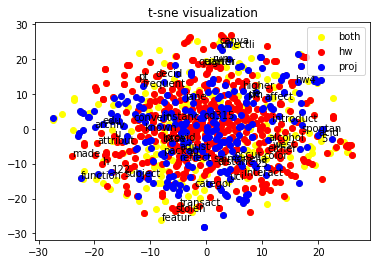

In [12]:
fig, ax = plt.subplots()
ax.scatter(tsne_X[:,0],tsne_X[:,1], c='yellow', label='both')
ax.scatter(tsne_X[only_hw_idx,0],tsne_X[only_hw_idx,1], c='red', label='hw')
ax.scatter(tsne_X[only_proj_idx,0],tsne_X[only_proj_idx,1], c='blue', label='proj')

for i in n:
    ax.annotate(w[i], (tsne_X[i,0],tsne_X[i,1]))
plt.legend()
plt.title("t-sne visualization")
plt.show()

## 11. Word Embeding in gensim:
    In this section, the PCA and t-sne visualization are also been showned.
    For the word embedding, I choose a window of 3,
    and disgard the words showed less than 3 times.
    Still, there is no clusting in neither PCA or t-SNE.

In [13]:
w_for_model = [word_tokenize(s) for s in whole_corpus]

model = Word2Vec(w_for_model, min_count=3, size=32, window=3)
gensim_w = list(model.wv.vocab)
X_form_model = model.wv.__getitem__(gensim_w)
pca_X_form_model = PCA(X_form_model)

[1.38314952e-04 1.29392510e-04 1.21276956e-04 1.19591339e-04
 1.15978356e-04 1.13423084e-04 1.08716572e-04 1.06763063e-04
 1.04825884e-04 1.01549226e-04 9.54208901e-05 9.29957247e-05
 9.02043255e-05 8.67225779e-05 8.42294935e-05 8.04752227e-05
 8.01766235e-05 7.69580061e-05 7.61624153e-05 7.35338696e-05
 6.93721430e-05 6.66444369e-05 6.34521751e-05 6.08109074e-05
 5.89741368e-05 5.62430010e-05 5.46326281e-05 5.10056484e-05
 4.66639299e-05 4.49433257e-05 4.36362535e-05 4.03407005e-05]


In [14]:
idx_hw_model = []
idx_proj_model = []

for i,word in enumerate(gensim_w):
    if word not in proj_words:
        idx_hw_model.append(i)
    if word not in hw_words:
        idx_proj_model.append(i)

## 12. The corresponding PCA graph and T-SNE graph:
    The vector space is from the word embedding with gensim library.

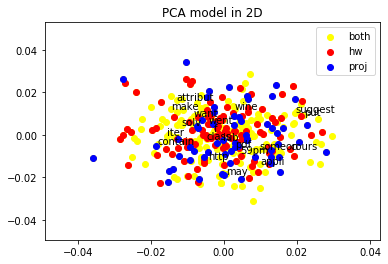

In [15]:
fig, ax = plt.subplots()
ax.scatter(pca_X_form_model[:,0],pca_X_form_model[:,1], c='yellow', label='both')
ax.scatter(pca_X_form_model[idx_hw_model,0],pca_X_form_model[idx_hw_model,1], c='red', label='hw')
ax.scatter(pca_X_form_model[idx_proj_model,0],pca_X_form_model[idx_proj_model,1], c='blue', label='proj')

for i in n[:20]:
    ax.annotate(gensim_w[i], (pca_X_form_model[i,0],pca_X_form_model[i,1]))
plt.title('PCA model in 2D')
plt.legend()
plt.show()

In [16]:
model_gen = TSNE(n_components=2)
tsne_X_gen = model_gen.fit_transform(X_form_model)

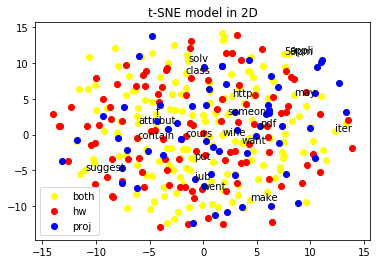

In [17]:
fig, ax = plt.subplots()
ax.scatter(tsne_X_gen[:,0],tsne_X_gen[:,1], c='yellow', label='both')
ax.scatter(tsne_X_gen[idx_hw_model,0],tsne_X_gen[idx_hw_model,1], c='red', label='hw')
ax.scatter(tsne_X_gen[idx_proj_model,0],tsne_X_gen[idx_proj_model,1], c='blue', label='proj')

for i in n[:20]:
    ax.annotate(gensim_w[i], (tsne_X_gen[i,0],tsne_X_gen[i,1]))
plt.title('t-SNE model in 2D')
plt.legend()
plt.show()

## 13. Linear discriminant analysis with three labels:
    After I tried unsupervised learning, 
    I decided to use the information from the label,
    where 0 repersent hw words, 1 repersent project words, 2 repersent both.
    I draw the graph after using LDA.
    Still, there is no obvious clusting.

In [18]:
lda_X = []
lda_y = []

for i,word in enumerate(gensim_w):
    if word not in proj_words:
        lda_X.append(X_form_model[i])
        lda_y.append(0)
    if word not in hw_words:
        lda_X.append(X_form_model[i])
        lda_y.append(1)
    if word in proj_words:
        if word in hw_words:
            lda_X.append(X_form_model[i])
            lda_y.append(2)
    
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(lda_X, lda_y)
new_lda_X = lda.transform(lda_X)

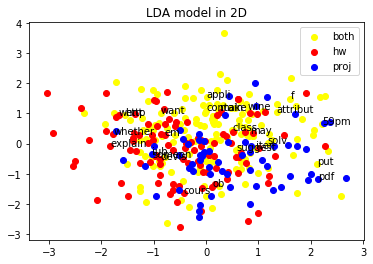

In [19]:
fig, ax = plt.subplots()
id1 = []
id2 = []
id3 = []
for i,label in enumerate(lda_y):
    if label==0:
        id1.append(i)
    if label==1:
        id2.append(i)
    if label==2:
        id3.append(i)
    
ax.scatter(new_lda_X[id3,0],new_lda_X[id3,1], c='yellow', label='both')
ax.scatter(new_lda_X[id1,0],new_lda_X[id1,1], c='red', label='hw')
ax.scatter(new_lda_X[id2,0],new_lda_X[id2,1], c='blue', label='proj')

for i in n[:25]:
    ax.annotate(gensim_w[i], (new_lda_X[i,0],new_lda_X[i,1]))
plt.title('LDA model in 2D')
plt.legend()
plt.show()

## 14. The Graph Convolutional Network and visualization:
    Graph Convolutional Networka(gcn) is a powerful type of neural network 
    designed to work directly on graphs and leverage their structural information.
    I applied it on my words graph, 
    where the words are the nodes and their 32D vector is their feature,
    and their neighbours are the words show before them and after them in a sentance.

In [20]:
data_layer = keras.layers.Input(shape=(None, EMBEDDING_DIM))
edge_layer = keras.layers.Input(shape=(None, None))
conv_layer = GraphConv(
    units=EMBEDDING_DIM,
    step_num=2,
)([data_layer, edge_layer])

model = keras.models.Model(inputs=[data_layer, edge_layer], outputs=conv_layer)
model.compile(
            optimizer='adam',
            loss='mae',
            metrics=['mae'],
        )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 32)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, None)   0                                            
__________________________________________________________________________________________________
graph_conv_1 (GraphConv)        (None, None, 32)     1056        input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 1,056
Trainable params: 1,056
Non-trainable params: 0
__________________________________________________________________________________________________


In [21]:
matrix = np.zeros([ONE_HOT_DIM, ONE_HOT_DIM])
for x, y in zip(df['input'], df['output']):
    matrix[word2int[x]][word2int[y]] = 1

predicts = model.predict([[vectors], [matrix]])
gcn_X = predicts[0]

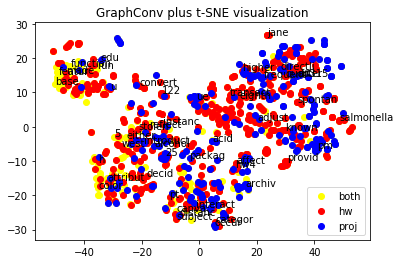

In [22]:
gcn_tsne = TSNE(n_components=2)
gcn_X = model_gen.fit_transform(gcn_X)

fig, ax = plt.subplots()
ax.scatter(gcn_X[:,0],gcn_X[:,1], c='yellow', label='both')
ax.scatter(gcn_X[only_hw_idx,0],gcn_X[only_hw_idx,1], c='red', label='hw')
ax.scatter(gcn_X[only_proj_idx,0],gcn_X[only_proj_idx,1], c='blue', label='proj')

for i in n:
    ax.annotate(w[i], (gcn_X[i,0],gcn_X[i,1]))
plt.legend()
plt.title("GraphConv plus t-SNE visualization")
plt.show()